In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'
BATCH_SIZE = 64
Epochs = 10
print('torch version : {}'.format(torch.__version__))
print('torch device : {}'.format(DEVICE))
print('Batch size : {}\nEpochs : {}'.format(BATCH_SIZE, Epochs))

torch version : 1.7.1+cu110
torch device : cuda
Batch size : 64
Epochs : 10


In [3]:
train_datasets = datasets.CIFAR10(root = './Data/CIFAR_10',train=True,download=True,transform=transforms.ToTensor())
test_datasets = datasets.CIFAR10(root = './Da   ta/CIFAR_10',train=False,download=True,transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_datasets, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_datasets, batch_size = BATCH_SIZE, shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
for (x_train, y_train) in train_loader:
    print("x_train 의 size : {}".format(x_train.size()))
    print("y_train 의 size : {}".format(y_train.size()))
    break

x_train 의 size : torch.Size([64, 3, 32, 32])
y_train 의 size : torch.Size([64])


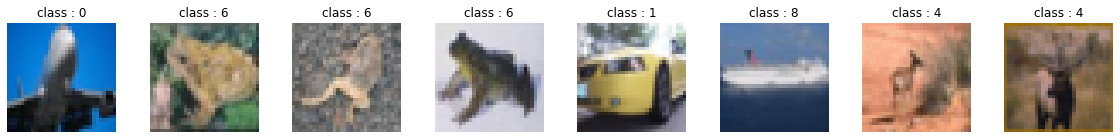

In [5]:
pltsize = 2
plt.figure(figsize = (10 * pltsize, pltsize))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(x_train[i],(1,2,0)))
    plt.title('class : ' + str(y_train[i].item()))

In [33]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32, 10)
    
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1,8*8*16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        
        return x

In [34]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr =0.01)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [35]:
def train(model, train_loader, optimizer, log_interval):
    model.train()

    for batch_idx,(image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)

        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch : {} [ {} / {} ( {:.0f}% ) ]'.format(Epoch, batch_idx * len(image), len(train_loader.dataset), 100 * batch_idx / len(train_loader)), end = ',  ')
            print('Train Loss : {:.6f}'.format(loss.item()))

In [36]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)

            output = model(image)
            test_loss += criterion(output,label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
        
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100 * correct / len(test_loader.dataset)

        return test_loss, test_accuracy
        

In [37]:
for Epoch in range(1, Epochs+1):
    train(model, train_loader, optimizer, 200)
    test_loss, test_accracy = evaluate(model, test_loader)
    print("\n[Epoch : {}], \t Test Loss : {:.4f}, \t Test Accuracy : {:.2f} %\n".format(Epoch, test_loss, test_accracy))

C:\Users\JAEYOU~1\AppData\Local\Temp/ipykernel_11968/3664862933.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch : 1 [ 0 / 50000 ( 0% ) ],  Train Loss : 2.303814
Train Epoch : 1 [ 12800 / 50000 ( 26% ) ],  Train Loss : 1.709300
Train Epoch : 1 [ 25600 / 50000 ( 51% ) ],  Train Loss : 1.500759
Train Epoch : 1 [ 38400 / 50000 ( 77% ) ],  Train Loss : 1.807929

[Epoch : 1], 	 Test Loss : 0.0222, 	 Test Accuracy : 48.31 %

Train Epoch : 2 [ 0 / 50000 ( 0% ) ],  Train Loss : 1.300448
Train Epoch : 2 [ 12800 / 50000 ( 26% ) ],  Train Loss : 1.714383
Train Epoch : 2 [ 25600 / 50000 ( 51% ) ],  Train Loss : 1.574228
Train Epoch : 2 [ 38400 / 50000 ( 77% ) ],  Train Loss : 1.583109

[Epoch : 2], 	 Test Loss : 0.0217, 	 Test Accuracy : 50.55 %

Train Epoch : 3 [ 0 / 50000 ( 0% ) ],  Train Loss : 1.305333
Train Epoch : 3 [ 12800 / 50000 ( 26% ) ],  Train Loss : 1.586860
Train Epoch : 3 [ 25600 / 50000 ( 51% ) ],  Train Loss : 1.423949
Train Epoch : 3 [ 38400 / 50000 ( 77% ) ],  Train Loss : 1.654890

[Epoch : 3], 	 Test Loss : 0.0203, 	 Test Accuracy : 54.31 %

Train Epoch : 4 [ 0 / 50000 ( 0% )